In [1]:
import random
import time
import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Sampler
import torchvision.datasets as datasets

In [2]:
data_directory = './'

torchvision.datasets.Flowers102(root=f'{data_directory}', download=True)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./
    split=train

In [3]:
image_size = 224

n_way = 20
k_shot = 4
n_query = 6
n_epochs = 10
n_train_tasks = 100
n_val_tasks = 100
n_test_tasks = 1000

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size)),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]
)

In [5]:
training_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='train', transform=transform)
validation_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='val', transform=transform)
test_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='test', transform=transform)

print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [6]:
training_set.get_labels = lambda: [
    instance for instance in training_set._labels
]

validation_set.get_labels = lambda: [
    instance for instance in validation_set._labels
]

test_set.get_labels = lambda: [
    instance for instance in test_set._labels
]

In [7]:
class TaskSampler(Sampler):
    
    def __init__(self, dataset, n_way, k_shot, n_query, n_tasks):
        super().__init__(data_source=None)
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_tasks = n_tasks
        self.n_query = n_query
        
        self.items_per_label = {}
        
        for item, label in enumerate(dataset.get_labels()):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]
                
    def __len__(self):
        return self.n_tasks
    
    def __iter__(self):
        for task in range(self.n_tasks):
            yield torch.cat(
                [
                    torch.Tensor(random.sample(self.items_per_label[label], self.k_shot + self.n_query)).type(torch.int)
                    
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            ).tolist()
            
    def collate_fn(self, input_data):
        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.k_shot + self.n_query, *all_images.shape[1:])
        )

        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.k_shot + self.n_query))

        support_images = all_images[:, : self.k_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.k_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.k_shot].flatten()
        query_labels = all_labels[:, self.k_shot :].flatten()

        return support_images, support_labels, query_images, query_labels, true_class_ids

In [8]:
train_sampler = TaskSampler(training_set, n_way, k_shot, n_query, n_train_tasks)
validation_sampler = TaskSampler(validation_set, n_way, k_shot, n_query, n_val_tasks)
test_sampler = TaskSampler(test_set, n_way, k_shot, n_query, n_test_tasks)

train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_sampler=train_sampler,
    collate_fn=train_sampler.collate_fn,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_sampler=validation_sampler,
    collate_fn=validation_sampler.collate_fn,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_sampler=test_sampler,
    collate_fn=test_sampler.collate_fn,
)

In [9]:
def evaluate_model(model, criterion, data_loader):
    
    model.eval()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    start_time = time.time()
    
    with tqdm.tqdm(data_loader, total=len(data_loader)) as tqdm_validation:
    
        for support_images, support_labels, query_images, query_labels, _ in tqdm_validation:

            support_images = support_images.to(device)
            support_labels = support_labels.to(device)
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)

            scores = model(support_images, support_labels, query_images)

            loss = criterion(scores, query_labels)

            running_loss += loss.item()
            total += query_labels.shape[0]
            _, preds = torch.max(scores, 1)
            running_correct += torch.sum(preds == query_labels).item()
            
            tqdm_validation.set_postfix(loss=loss.item(), acc=running_correct/total)

    end_time = time.time()
    
    print(f'Loss: {running_loss / len(data_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
    
    return running_loss / len(data_loader), running_correct / total

In [10]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
            
    best_val_acc = 0
    best_state = model.state_dict()
    
    total_time = 0.0
    
    for epoch in range(num_epochs):
        
        model.train()
        
        running_loss = 0.0
        running_correct = 0
        total = 0
        
        start_time = time.time()
        
        with tqdm.tqdm(train_loader, total=len(train_loader)) as tqdm_train:
            for support_images, support_labels, query_images, query_labels, _ in tqdm_train:
                support_images = support_images.to(device)
                support_labels = support_labels.to(device)
                query_images = query_images.to(device)
                query_labels = query_labels.to(device)

                optimizer.zero_grad()

                scores = model(support_images, support_labels, query_images)

                loss = criterion(scores, query_labels)

                running_loss += loss.item()
                total += query_labels.shape[0]
                _, preds = torch.max(scores, 1)
                running_correct += torch.sum(preds == query_labels).item()

                loss.backward()
                optimizer.step()
                
                tqdm_train.set_postfix(loss=loss.item(), acc=running_correct/total)

            end_time = time.time()

            scheduler.step()
        
        print(f'Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
        
        total_time += end_time - start_time
        
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(running_correct / total)
        
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        if (val_acc > best_val_acc):
            best_val_acc = val_acc
            best_state = model.state_dict()
        
    print(f'Average Training Time: {total_time / num_epochs}')
    return best_state, [train_loss_history, train_acc_history, val_loss_history, val_acc_history]

In [11]:
class PrototypicalNetworks(torch.nn.Module):
    def __init__(self, backbone, dist_fn="euclidean"):
        super().__init__()
        
        self.backbone = backbone
        self.dist_fn = dist_fn
        
        if (self.dist_fn == "euclidean"):
            self.dist_function = self.euclidean
        else:
            self.dist_function = self.cosine_similarity
        
    def euclidean(self, z_query, z_proto, p=2.0):
        dists = torch.cdist(z_query, z_proto, p=p)
        return -dists
    
    def cosine_similarity(self, z_query, z_proto):
        return z_query.mm(torch.nn.functional.normalize(z_proto).T)

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        scores = self.dist_function(z_query, z_proto)
        return scores

In [12]:
convolutional_network = torchvision.models.resnet18(pretrained=True)
convolutional_network.fc = torch.nn.Flatten()

model = PrototypicalNetworks(convolutional_network, "cosine")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

best_state, history = train(model, criterion, optimizer, lr_scheduler, train_loader, validation_loader, num_epochs=n_epochs)

100%|██████████| 100/100 [03:39<00:00,  2.19s/it, acc=0.99, loss=0.00471]


Epoch: 1, Loss: 0.08052118123043328, Accuracy: 0.9903333333333333, Time: 219.0622s


100%|██████████| 100/100 [03:11<00:00,  1.92s/it, acc=0.954, loss=0.144]


Loss: 0.20394047930836678, Accuracy: 0.9535, Time: 191.6992s


100%|██████████| 100/100 [03:32<00:00,  2.12s/it, acc=1, loss=0.000964]


Epoch: 2, Loss: 0.002987529742531478, Accuracy: 1.0, Time: 212.4756s


100%|██████████| 100/100 [03:12<00:00,  1.92s/it, acc=0.954, loss=0.172]


Loss: 0.19116363801062108, Accuracy: 0.9544166666666667, Time: 192.1627s


100%|██████████| 100/100 [03:36<00:00,  2.17s/it, acc=1, loss=0.00213]


Epoch: 3, Loss: 0.0020538011874305082, Accuracy: 1.0, Time: 216.8612s


100%|██████████| 100/100 [03:14<00:00,  1.94s/it, acc=0.954, loss=0.242]


Loss: 0.197004189863801, Accuracy: 0.9541666666666667, Time: 194.1180s


100%|██████████| 100/100 [03:33<00:00,  2.14s/it, acc=1, loss=0.00176]


Epoch: 4, Loss: 0.001772209220798686, Accuracy: 1.0, Time: 213.5228s


100%|██████████| 100/100 [03:12<00:00,  1.92s/it, acc=0.957, loss=0.18]


Loss: 0.18192335210740565, Accuracy: 0.9571666666666667, Time: 192.3316s


100%|██████████| 100/100 [03:35<00:00,  2.16s/it, acc=1, loss=0.00196]


Epoch: 5, Loss: 0.0016660211671842263, Accuracy: 1.0, Time: 215.6687s


100%|██████████| 100/100 [03:11<00:00,  1.92s/it, acc=0.958, loss=0.319]


Loss: 0.18361926898360253, Accuracy: 0.95775, Time: 192.0055s


100%|██████████| 100/100 [03:34<00:00,  2.15s/it, acc=1, loss=0.00155]


Epoch: 6, Loss: 0.0016326618538005278, Accuracy: 1.0, Time: 214.7338s


100%|██████████| 100/100 [03:14<00:00,  1.94s/it, acc=0.958, loss=0.186]


Loss: 0.17876987379044296, Accuracy: 0.95825, Time: 194.1314s


100%|██████████| 100/100 [03:34<00:00,  2.14s/it, acc=1, loss=0.00225]


Epoch: 7, Loss: 0.0015698806964792311, Accuracy: 1.0, Time: 214.1009s


100%|██████████| 100/100 [03:12<00:00,  1.92s/it, acc=0.958, loss=0.123]


Loss: 0.1930264288187027, Accuracy: 0.9575, Time: 192.4668s


100%|██████████| 100/100 [03:35<00:00,  2.16s/it, acc=1, loss=0.00143]


Epoch: 8, Loss: 0.0015537384198978544, Accuracy: 1.0, Time: 215.8653s


100%|██████████| 100/100 [03:13<00:00,  1.93s/it, acc=0.959, loss=0.145]


Loss: 0.1806570428609848, Accuracy: 0.95875, Time: 193.2056s


100%|██████████| 100/100 [03:33<00:00,  2.14s/it, acc=1, loss=0.000987]


Epoch: 9, Loss: 0.0015667241264600306, Accuracy: 1.0, Time: 213.9148s


100%|██████████| 100/100 [03:13<00:00,  1.94s/it, acc=0.955, loss=0.199]


Loss: 0.1877829710394144, Accuracy: 0.9549166666666666, Time: 193.6946s


100%|██████████| 100/100 [03:33<00:00,  2.14s/it, acc=1, loss=0.00251]


Epoch: 10, Loss: 0.0015954709151992574, Accuracy: 1.0, Time: 213.6526s


100%|██████████| 100/100 [03:16<00:00,  1.97s/it, acc=0.957, loss=0.236]

Loss: 0.1841950061172247, Accuracy: 0.9568333333333333, Time: 196.6009s
Average Training Time: 214.98580572605132


In [14]:
train_loss, train_acc, val_loss, val_acc = history

In [15]:
def plot_curve(train_history, val_history, title='Model Accuracy', ylabel='Accuracy', legend_loc='upper left'):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc=legend_loc)
    
    plt.show()

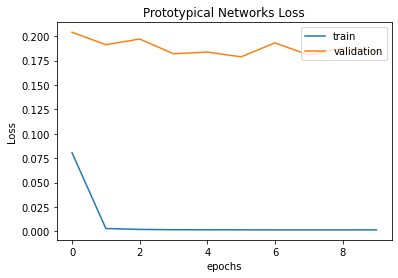

In [16]:
plot_curve(train_loss, val_loss, title='Prototypical Networks Loss', ylabel='Loss', legend_loc='upper right')

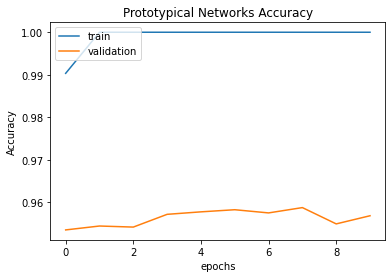

In [17]:
plot_curve(train_acc, val_acc, title='Prototypical Networks Accuracy', ylabel='Accuracy', legend_loc='upper left')

In [18]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [19]:
print('Train: ', end='')
evaluate_model(model, criterion, train_loader);

Train: 

100%|██████████| 100/100 [03:11<00:00,  1.92s/it, acc=1, loss=0.000991]

Loss: 0.0010314689809456468, Accuracy: 1.0, Time: 191.8663s


In [20]:
print('Validation: ', end='')
evaluate_model(model, criterion, validation_loader);

Validation: 

100%|██████████| 100/100 [03:13<00:00,  1.93s/it, acc=0.96, loss=0.238]

Loss: 0.17062253229320049, Accuracy: 0.9604166666666667, Time: 193.3135s


In [21]:
print('Test: ', end='')
evaluate_model(model, criterion, test_loader);

Test: 

100%|██████████| 1000/1000 [33:09<00:00,  1.99s/it, acc=0.948, loss=0.218]

Loss: 0.20176957058161496, Accuracy: 0.9479166666666666, Time: 1989.3194s


In [22]:
# def evaluate_on_one_task(
#     support_images: torch.Tensor,
#     support_labels: torch.Tensor,
#     query_images: torch.Tensor,
#     query_labels: torch.Tensor,
# ) -> [int, int]:
#     """
#     Returns the number of correct predictions of query labels, and the total number of predictions.
#     """
#     return (
#         torch.max(
#             model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
#             .detach()
#             .data,
#             1,
#         )[1]
#         == query_labels.cuda()
#     ).sum().item(), len(query_labels)


# def evaluate(data_loader: DataLoader):
#     # We'll count everything and compute the ratio at the end
#     total_predictions = 0
#     correct_predictions = 0

#     # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
#     # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
#     model.eval()
#     with torch.no_grad():
#         for episode_index, (
#             support_images,
#             support_labels,
#             query_images,
#             query_labels,
#             class_ids,
#         ) in tqdm(enumerate(data_loader), total=len(data_loader)):

#             correct, total = evaluate_on_one_task(
#                 support_images, support_labels, query_images, query_labels
#             )

#             total_predictions += total
#             correct_predictions += correct

#     print(
#         f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
#     )

#     return correct_predictions / total_predictions


In [23]:
# (
#     example_support_images,
#     example_support_labels,
#     example_query_images,
#     example_query_labels,
#     example_class_ids,
# ) = next(iter(test_loader))

# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)
# print(example_support_labels)
# print(example_query_labels)

In [24]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)


# def fit(
#     support_images: torch.Tensor,
#     support_labels: torch.Tensor,
#     query_images: torch.Tensor,
#     query_labels: torch.Tensor,
# ) -> float:
#     optimizer.zero_grad()
#     classification_scores = model(
#         support_images.cuda(), support_labels.cuda(), query_images.cuda()
#     )

#     loss = criterion(classification_scores, query_labels.cuda())
#     loss.backward()
#     optimizer.step()

#     return loss.item()

In [25]:
# def training_epoch():
#     log_update_frequency = 10

#     all_loss = []
#     model.train()
#     with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
#         for episode_index, (
#           support_images,
#           support_labels,
#           query_images,
#           query_labels,
#           _,
#         ) in tqdm_train:
#             loss_value = fit(support_images, support_labels, query_images, query_labels)
#             all_loss.append(loss_value)

#             if episode_index % log_update_frequency == 0:
#                 tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

#     return mean(all_loss)

In [26]:
# best_state = model.state_dict()
# n_epochs=10
# best_validation_accuracy = 0.0
# for epoch in range(n_epochs):
#     print(f"Epoch {epoch}")
#     average_loss = training_epoch()
#     validation_accuracy = evaluate(val_loader)

#     if validation_accuracy > best_validation_accuracy:
#         best_validation_accuracy = validation_accuracy
#         best_state = model.state_dict()
#     print("best validation accuracy yet: ", best_validation_accuracy)

In [27]:
# model.load_state_dict(best_state)

In [28]:
# evaluate(test_loader)